In [357]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import math
import itertools
import scipy
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

import xgboost as xgb

from scipy.stats import chi2_contingency
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn import ensemble, metrics , datasets,tree
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

In [358]:
df = pd.read_excel('CVD_ALL People.xlsx')

In [456]:
df[['Дата снятия с учёта','Дата получения положительного теста', 'Дата постановки на учёт']]

,Дата снятия с учёта,Дата получения положительного теста,Дата постановки на учёт
0,2020-11-18,2020-10-04,2020-10-06
1,2020-10-26,2020-09-28,2020-10-01
2,NaT,2020-12-17,2020-12-17
3,2020-11-10,2020-10-04,2020-10-06
4,2020-11-05,2020-10-19,2020-10-20
...,...,...,...
30938,2020-10-28,2020-10-10,2020-10-12
30939,NaT,2020-12-05,2020-12-07
30941,2020-10-15,2020-09-21,2020-09-28
30942,NaT,2020-12-02,2020-12-03


In [359]:
df.columns

Index(['ИД', 'Наименование организации', 'ФИО работника', 'Должность',
       'Гражданство', 'Год рождения', 'Город', 'Статус города',
       'Место прохождения лечения', 'Наименование стационара', 'ФМБА',
       'Степень тяжести заболевания', 'Количество контактировавших', 'Страна',
       'Статус учёта', 'Дата снятия с учёта',
       'Дата получения положительного теста', 'Дата постановки на учёт',
       'Дата смерти', 'Комментарий', 'Кем изменено', 'Изменено', 'Создано',
       'Тип элемента', 'Путь'],
      dtype='object')

### Feature Gen

In [360]:
# Время болезни
df['Время болезни']=((df['Дата снятия с учёта'] - df['Дата постановки на учёт']) / np.timedelta64(1, 'D')).fillna(0).astype(int)

In [361]:
# Возраст
import datetime
first_time = df['Год рождения'].str.replace(r'\D', '0').fillna(0).astype(int)
later_time = datetime.datetime.now().year
later_time - first_time
df['Возраст'] = later_time - first_time

In [362]:
# Неделя постановки на учёт
df['Неделя постановки на учёт'] = df['Дата постановки на учёт'].apply(lambda x: x.isocalendar()[1] if x!= 'Nan' else 0 )

In [411]:
df = df[df['Дата получения положительного теста'].notna()]

In [422]:
df['Дата получения положительного теста'] = pd.to_datetime(df['Дата получения положительного теста'], errors='coerce')

In [425]:
# День недели получения положительного результата
df['День недели результата'] = df['Дата получения положительного теста'].dt.dayofweek

In [363]:
df['Степень тяжести заболевания'].value_counts()

Легкая             22441
Бессимптомно        2405
Средней тяжести     1177
Тяжелая               59
Name: Степень тяжести заболевания, dtype: int64

In [364]:
df['Статус учёта'].value_counts()

Снят         23190
Поставлен     7627
Скончался      127
Name: Статус учёта, dtype: int64

<AxesSubplot:>

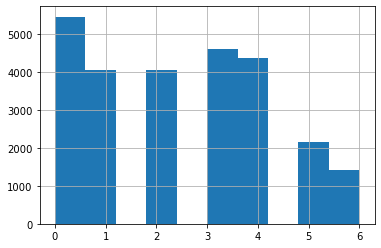

In [426]:
df['День недели результата'].hist()

<AxesSubplot:>

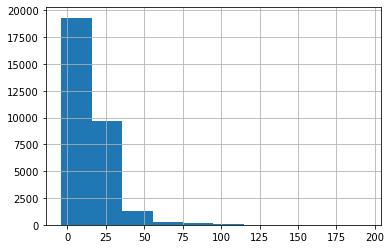

In [366]:
df['Время болезни'].hist()

In [435]:
df['Время болезни'].mean() , df['Время болезни'].median()

(14.585072908672295, 14.0)

In [367]:
# Дроп выбросов по перцентилям
df = df.drop( (df[df['Возраст'] <df['Возраст'].quantile(0.025)].index ) | (df[df['Возраст']>df['Возраст'].quantile(0.975)].index ) )
df['Возраст'].mean(), df['Возраст'].median()

(44.927133723487024, 44.0)

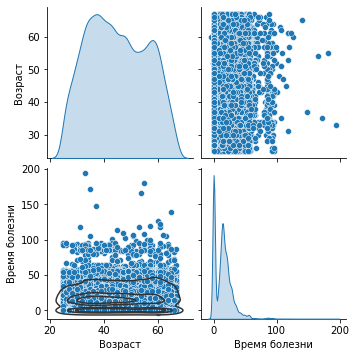

In [434]:
g = sns.pairplot(df[['Возраст','Время болезни']], diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
sns.pairplot(df[['Возраст'], hue="Степень тяжести заболевания")

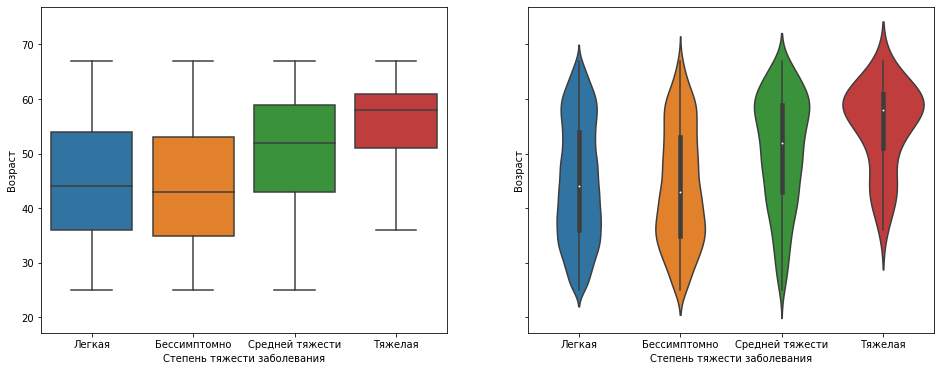

In [395]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))

sns.boxplot(x='Степень тяжести заболевания', y='Возраст', data=df, ax=axes[0]);
sns.violinplot(x='Степень тяжести заболевания', y='Возраст', data=df, ax=axes[1]);

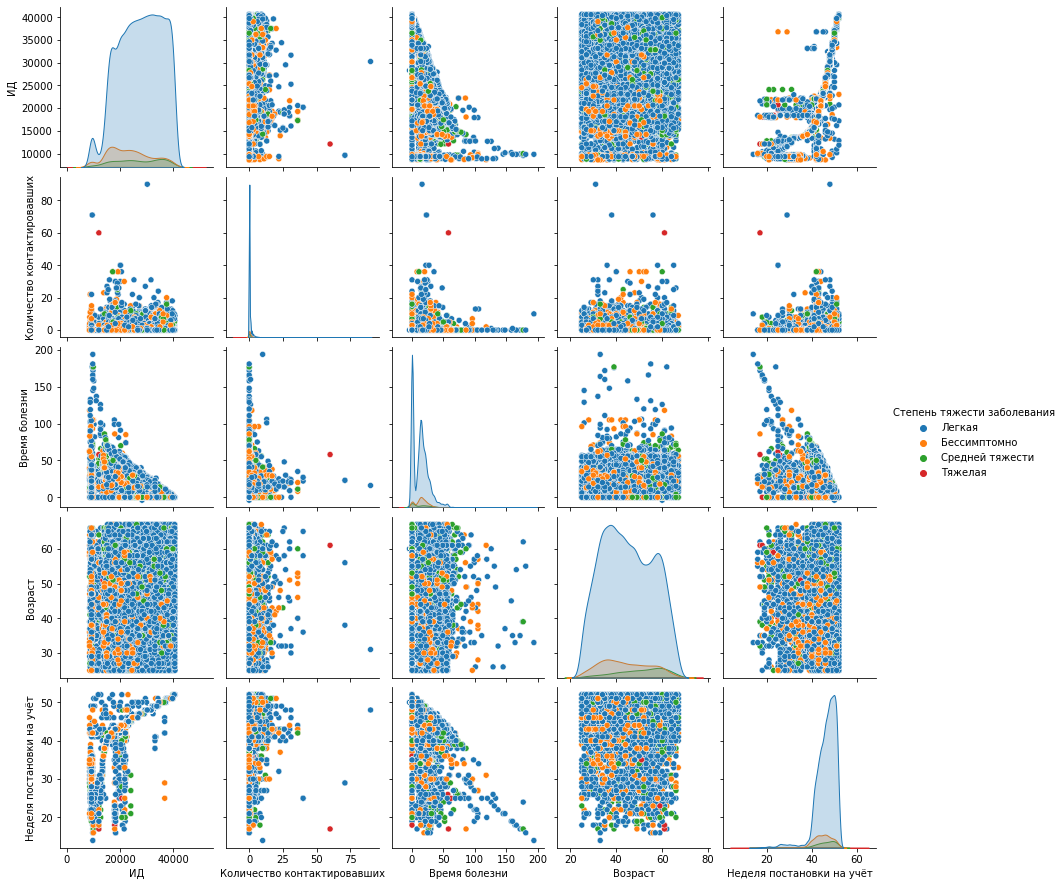

In [398]:
sns.pairplot(df, hue="Степень тяжести заболевания")

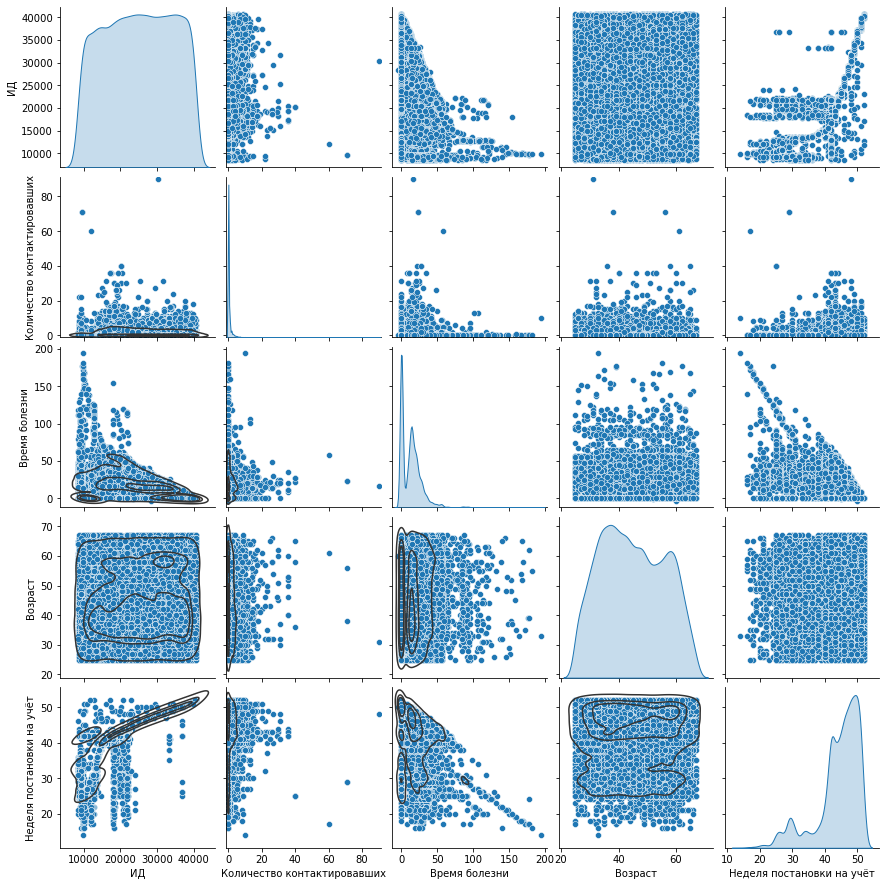

In [400]:
g = sns.pairplot(df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

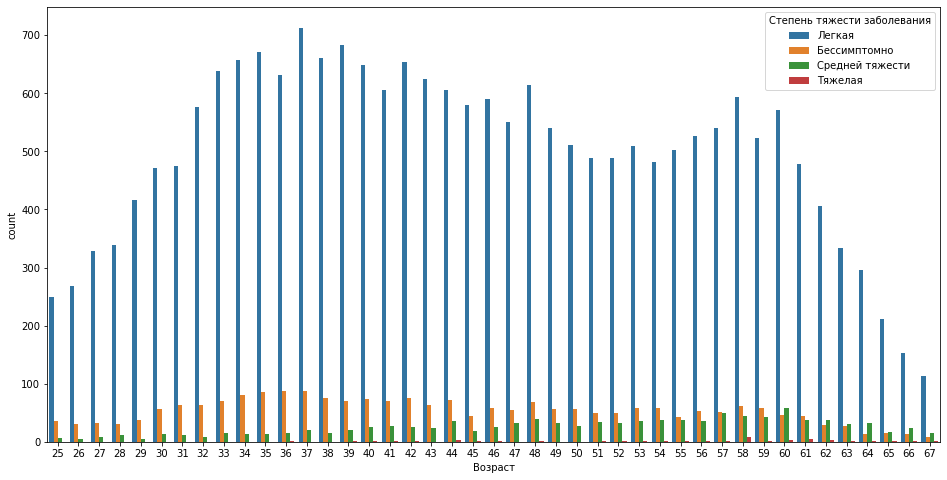

In [370]:
plt.figure(figsize=(16,8)) # this creates a figure 8 inch wide, 4 inch high
sns.countplot(x='Возраст', hue='Степень тяжести заболевания', data=df)
plt.show()

In [371]:
df.groupby(['Степень тяжести заболевания'])['Возраст'].mean()

Степень тяжести заболевания
Бессимптомно       43.936570
Легкая             44.962039
Средней тяжести    50.439091
Тяжелая            54.979167
Name: Возраст, dtype: float64

In [396]:
df.groupby(['Степень тяжести заболевания'])['Возраст'].median()

Степень тяжести заболевания
Бессимптомно       43
Легкая             44
Средней тяжести    52
Тяжелая            58
Name: Возраст, dtype: int32

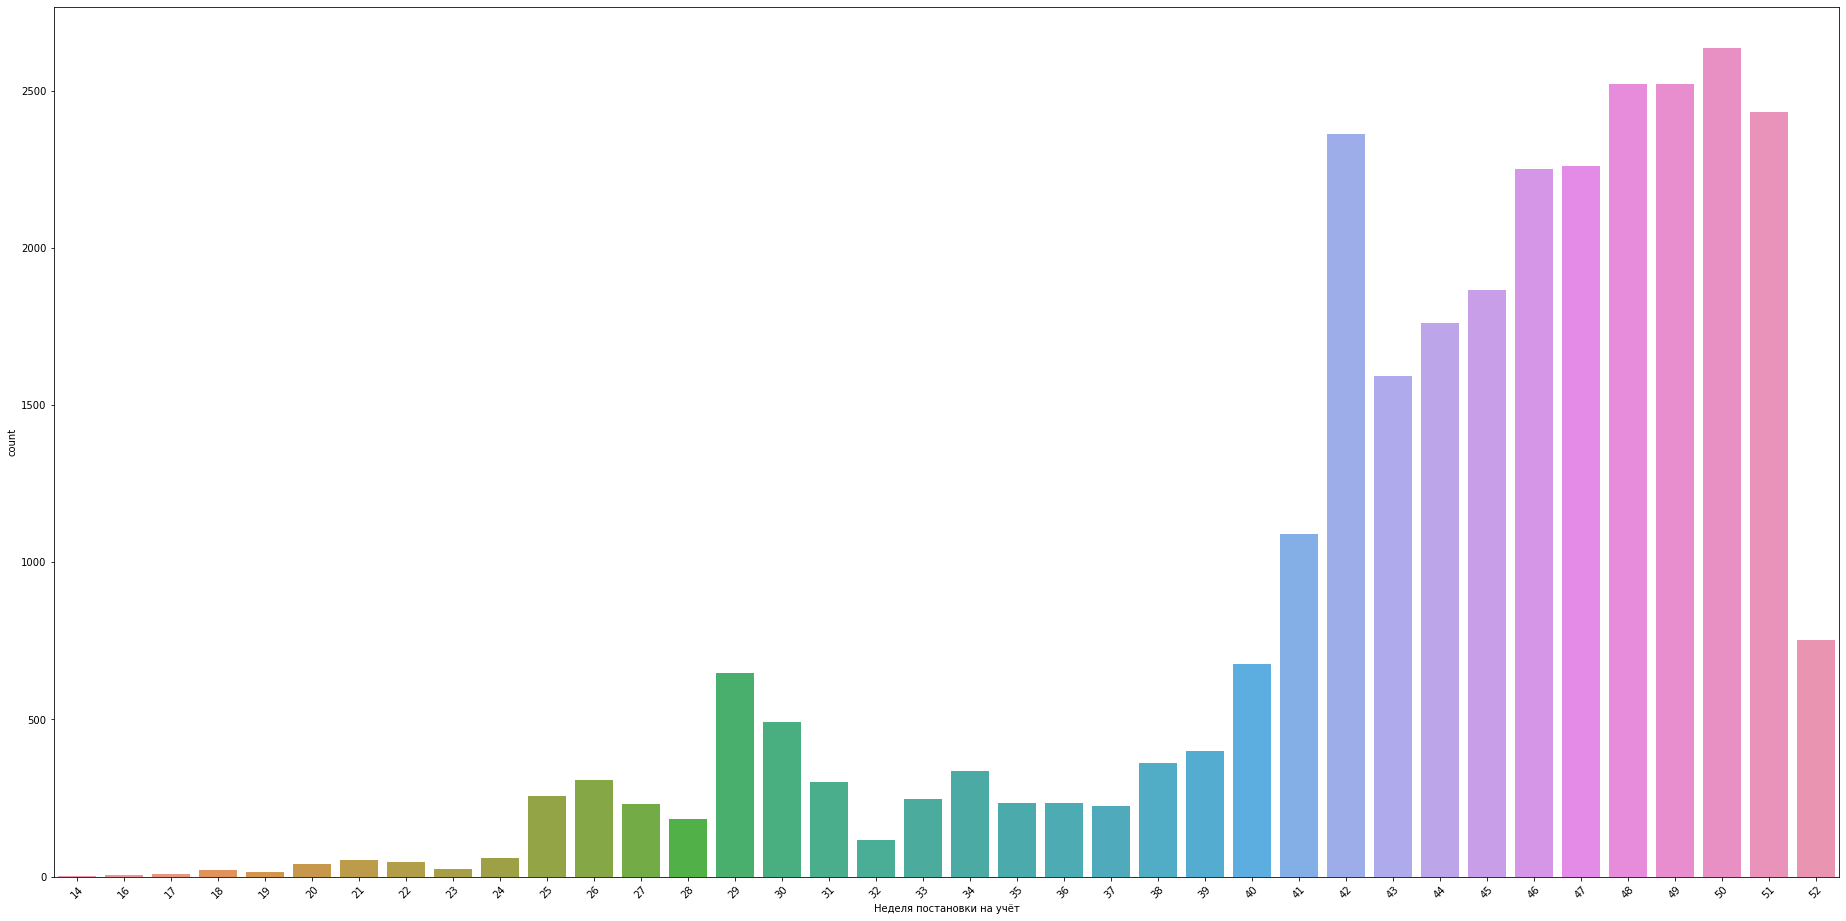

In [286]:
# Распределение количества заболевших по неделям
plt.figure(figsize=(32,16))
chart = sns.countplot(x='Неделя постановки на учёт', data=df[['Неделя постановки на учёт']].sort_values(axis=0, by = 'Неделя постановки на учёт') )
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

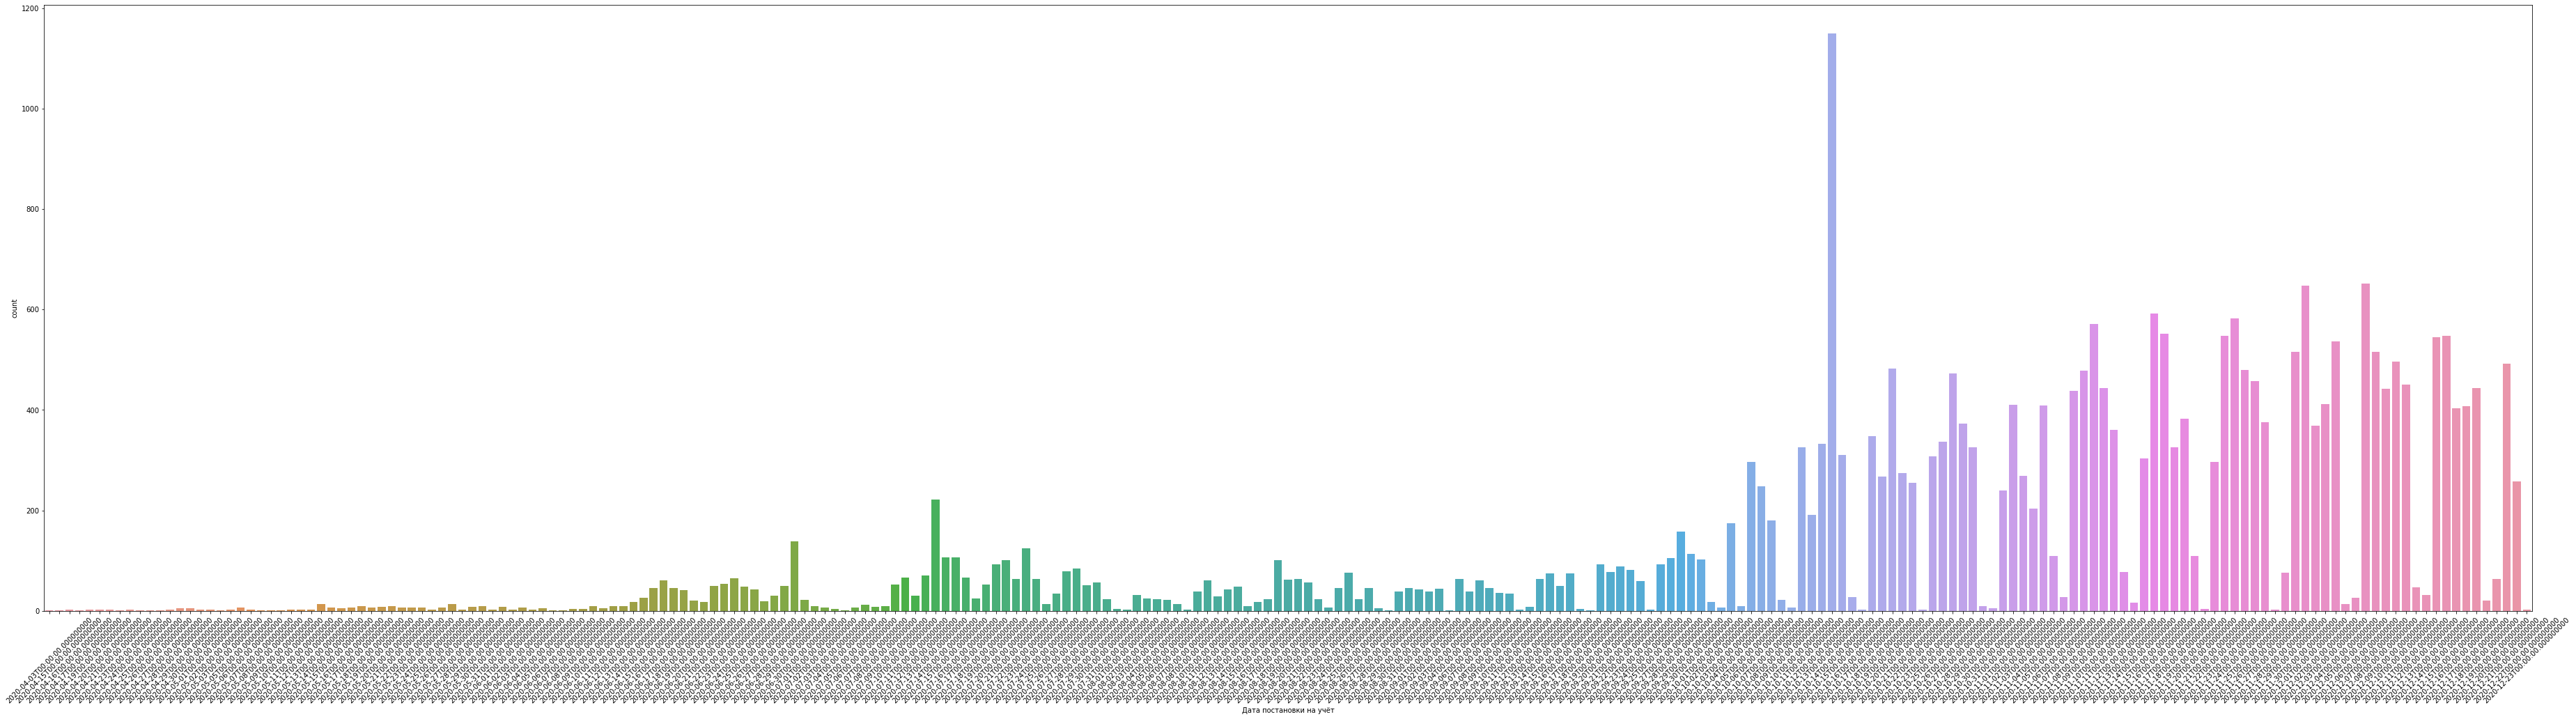

In [285]:
# Распределение количества заболевших по дням
plt.figure(figsize=(64,16))
chart = sns.countplot(x='Дата постановки на учёт', data=df[['Дата постановки на учёт']].sort_values(axis=0, by = 'Дата постановки на учёт') )
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [384]:
df['Должность'].value_counts()[:10].to_frame().style.bar()

,Должность
Инженер,2122
Главный специалист,900
Слесарь,865
ВедущийИнженер,794
Специалист,749
Ведущий специалист,740
Начальник отдела,604
Монтажник,601
Мастер,469
Инженер,412


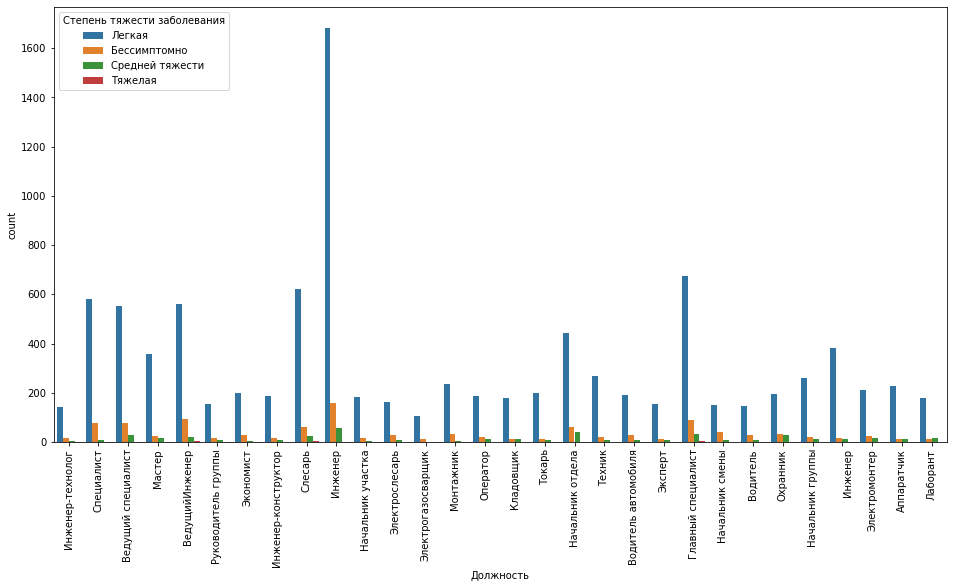

In [383]:
dfx = df[df['Должность'].isin(df['Должность'].value_counts()[:30].to_frame().style.bar().index)]

plt.figure(figsize=(16,8)) # this creates a figure 8 inch wide, 4 inch high
chart = sns.countplot(x='Должность', hue='Степень тяжести заболевания', data=dfx)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

In [386]:
df['Наименование организации'].value_counts()[:15].to_frame().style.bar()

,Наименование организации
"ФГУП ""РФЯЦ-ВНИИЭФ""",4757
"ФГУП ""ПО ""Маяк""",1322
"ФГУП ""Комбинат"" Электрохимприбор""",1187
"АО ""ОКБМ Африкантов""",884
"ФГУП ""ГХК""",821
"АО ""Атом-охрана""",712
Ленинградская АЭС,638
"ФГУП ""РФЯЦ-ВНИИТФ им.академ. Е.И. Забабахина""",535
"АО ИК ""АСЭ""",504
"АО ""УЭХК""",454


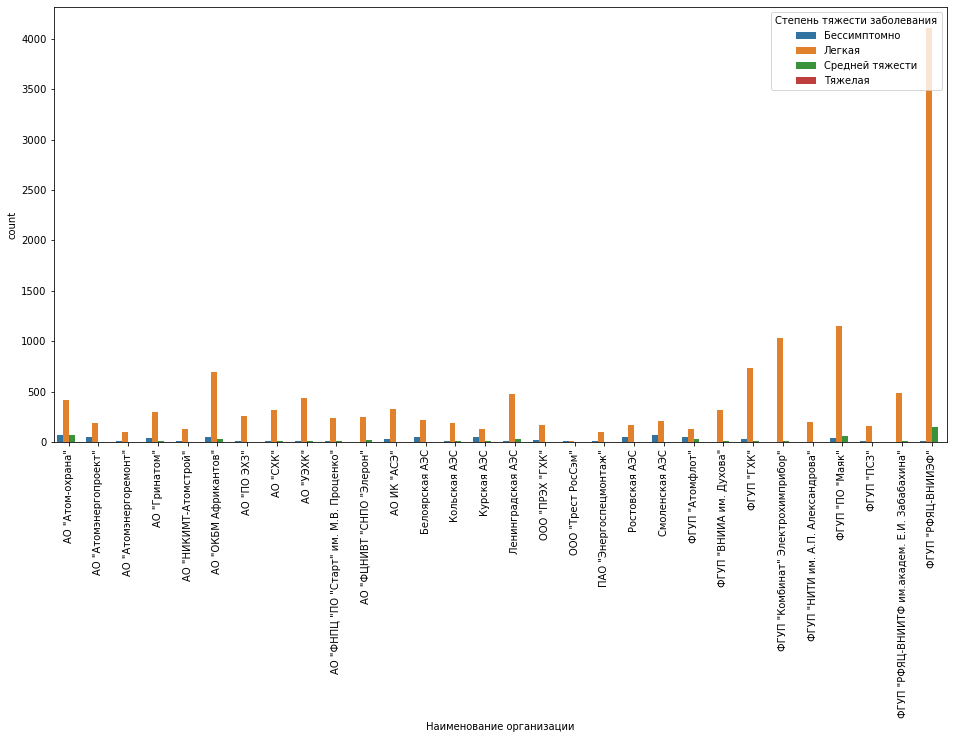

In [385]:
dfx = df[df['Наименование организации'].isin(df['Наименование организации'].value_counts()[:30].to_frame().style.bar().index)]

plt.figure(figsize=(16,8)) # this creates a figure 8 inch wide, 4 inch high
chart = sns.countplot(x='Наименование организации', hue='Степень тяжести заболевания', data=dfx)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

In [339]:
df['Гражданство'].value_counts()[:10].to_frame().style.bar()

,Гражданство
РФ,23358
Нет данных,4773
Беларусь,180
Украина,160
Чехия,19
Турция,17
Венгрия,12
!Не указано,7
Бангладеш,3
Армения,2


In [388]:
df['Место прохождения лечения'].value_counts()[:10].to_frame().style.bar()

,Место прохождения лечения
Самоизоляция по месту жительства,23224
Стационар,1095
Самоизоляция по месту пребывания,620
Уточняется,17


In [387]:
df['Наименование стационара'].value_counts()[:10].to_frame().style.bar()

,Наименование стационара
Нет данных,183
медицинский центр PDC,101
КБ № 50 ФМБА России,76
Popular Diagnostic Centre,57
КБ № 71 ФМБА России,47
КБ №50 г. Саров,47
Не распознано,44
"ФГБУЗ ""ЦМСЧ №15 ФМБА""",32
ФГБУЗ МСЧ 135 ФМБА России,31
МСЧ 125 г. Курчатов,27


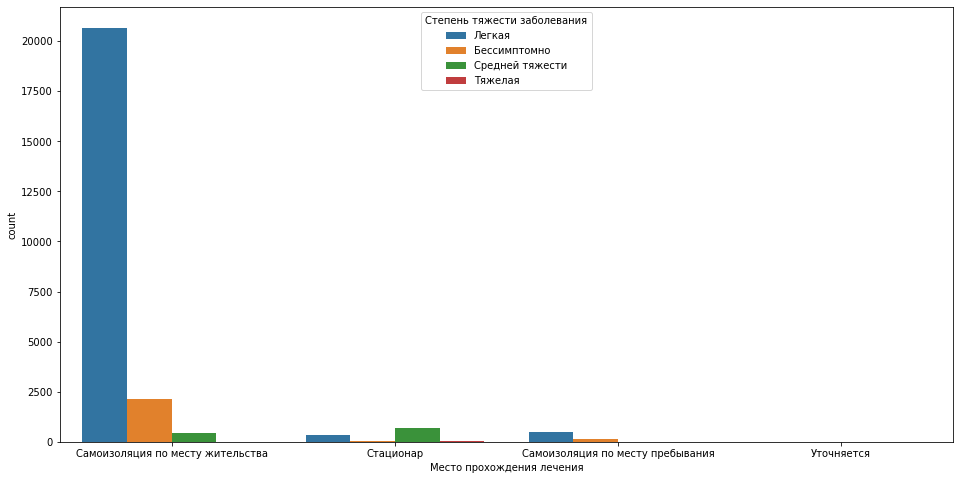

In [390]:
plt.figure(figsize=(16,8)) # this creates a figure 8 inch wide, 4 inch high
sns.countplot(x='Место прохождения лечения', hue='Степень тяжести заболевания', data=df)
plt.show()

## BASELINE

In [436]:
from pandas import read_csv
from matplotlib import pyplot
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [451]:
df[['Дата постановки на учёт']].sort_values(axis=0, by = 'Дата постановки на учёт').groupby(['Дата постановки на учёт']).size()

Дата постановки на учёт
2020-04-03      1
2020-04-15      1
2020-04-16      2
2020-04-17      1
2020-04-19      2
             ... 
2020-12-19     19
2020-12-20     64
2020-12-21    486
2020-12-22    256
2020-12-23      2
Length: 239, dtype: int64

In [452]:
df[['Дата снятия с учёта']].sort_values(axis=0, by = 'Дата снятия с учёта').groupby(['Дата снятия с учёта']).size()

Дата снятия с учёта
2020-05-02      1
2020-05-05      1
2020-05-08      1
2020-05-11      1
2020-05-14      2
             ... 
2020-12-20     90
2020-12-21    479
2020-12-22    338
2020-12-23     18
2020-12-27      1
Length: 204, dtype: int64